In [1]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
from gensim.utils import lemmatize, simple_preprocess
import logging
import tempfile
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import re
%matplotlib inline
import sys
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize 
import itertools
import collections
import tweepy as tw
from nltk import bigrams
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import iplot
from textblob import TextBlob

init_notebook_mode(connected=True) #do not miss this line

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [3]:
datafile='changiairport_150000.csv'

In [4]:
import pandas as pd
tweets = pd.read_csv(datafile, encoding='utf-8')
tweets = tweets.assign(Time=pd.to_datetime(tweets.time))

print("Number of tweets: ",len(tweets['text']))
tweets.head(5)

Number of tweets:  102352


text                 time  \
0  b'#Canopy Park at #Singapore #Jewel Changi Air...  2019-11-24 10:10:07   
1  b'Stop to see the waterfall before going to th...  2019-11-24 08:56:51   
2  b"Jewel Changi Airport, Singapore.\nImagine ha...  2019-11-24 07:39:05   
3  b'Mandatory shot at Jewel. Sadly #samsungs10 w...  2019-11-24 06:11:50   
4  b'when in Jewel \xf0\x9f\x98\x8e\n\ntaken by @...  2019-11-24 04:19:31   

            user_name  Retweet_Count                Time  
0     b'Cloverstar81'              0 2019-11-24 10:10:07  
1  b'Themoonworld_Ch'              0 2019-11-24 08:56:51  
2        b'Nwankpa_A'             13 2019-11-24 07:39:05  
3        b'bryanongg'              0 2019-11-24 06:11:50  
4      b'winkandpout'              0 2019-11-24 04:19:31

In [5]:
tweets['Time'] = pd.to_datetime(tweets['Time'], format='%y-%m-%d %H:%M:%S')
tweetsT = tweets['Time']

trace = go.Histogram(
    x=tweetsT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity',
    height=450,
    width=1200,
    xaxis=dict(
        title='Date'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [6]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

stop_words = set(stopwords.words('english'))
stop_words.update(('singapore','changi','airport','jewel','look','saw','im','changiairport','jewelchangiairport','like','see','got','go','use','taking','take'))

def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = tweet[1:]
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', '', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    #tweet= TextBlob(tweet).correct()
    words = tweet.split()
    use_stemmer = False
    porter_stemmer = PorterStemmer()
    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            if use_stemmer:
                word = str(porter_stemmer.stem(word))
            processed_tweet.append(word)
    #example_sent = "This is a sample sentence, showing off the stop words filtration."
  
    #stop_words.extend('singapore','jbkjbbk')
  
    #word_tokens = word_tokenize(processed_tweet) 
  
    filtered_sentence = [w for w in processed_tweet if not w in stop_words] 
  
    filtered_sentence = [] 
  
    for w in processed_tweet: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    return ' '.join(filtered_sentence)

tweets['clean_tweet'] = tweets.text.apply(preprocess_tweet)

In [7]:
tweets.head(10)

text                 time  \
0  b'#Canopy Park at #Singapore #Jewel Changi Air...  2019-11-24 10:10:07   
1  b'Stop to see the waterfall before going to th...  2019-11-24 08:56:51   
2  b"Jewel Changi Airport, Singapore.\nImagine ha...  2019-11-24 07:39:05   
3  b'Mandatory shot at Jewel. Sadly #samsungs10 w...  2019-11-24 06:11:50   
4  b'when in Jewel \xf0\x9f\x98\x8e\n\ntaken by @...  2019-11-24 04:19:31   
5  b'Blue Christmas in Singapore #changiairport #...  2019-11-24 03:13:00   
6  b'Amazing\xf0\x9f\x98\x81\n\n#SteeRexplore #ST...  2019-11-24 02:40:51   
7  b'In Jewel , changi Airport\xf0\x9f\x98\x98 ht...  2019-11-24 02:21:46   
8  b'#Singapore #changi #airport T4 all automated...  2019-11-24 02:07:46   
9  b'Jewel Changi Airport Ultimate Food Guide \xe...  2019-11-24 02:00:11   

            user_name  Retweet_Count                Time  \
0     b'Cloverstar81'              0 2019-11-24 10:10:07   
1  b'Themoonworld_Ch'              0 2019-11-24 08:56:51   
2        b'Nwankpa_A'             13 2019-11-24 07:39:05   
3        b'bryanongg'              0 2019-11-24 06:11:50   
4      b'winkandpout'              0 2019-11-24 04:19:31   
5         b'RonJabal'              0 2019-11-24 03:13:00   
6    b'Sunshinerer28'              0 2019-11-24 02:40:51   
7    b'Misnaoriflame'              0 2019-11-24 02:21:46   
8          b'harshap'              1 2019-11-24 02:07:46   
9  b'powersystemlead'              0 2019-11-24 02:00:11   

                                         clean_tweet  
0                                        canopy park  
1                               stop waterfall going  
2                         something umuahia thinking  
3  mandatory shot sadly samsungs10 wide shot wide...  
4                                                     
5                  blue christmas christmas holidays  
6                           steerexplore steescapade  
7                                                     
8  t4 automated boarding pass immigration clearan...  
9  ultimate food guide restaurants food places ex...

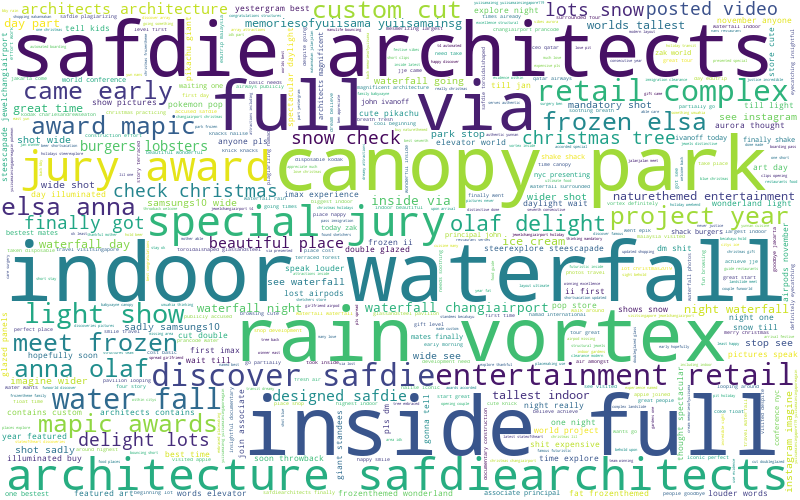

In [6]:
# Import the wordcloud library
from wordcloud import WordCloud# Join the different processed titles together.
long_string = ','.join(list(tweets['clean_tweet'].values))# Create a WordCloud object
wordcloud = WordCloud(width=800, height=500,background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)# Visualize the word cloud
wordcloud.to_image()

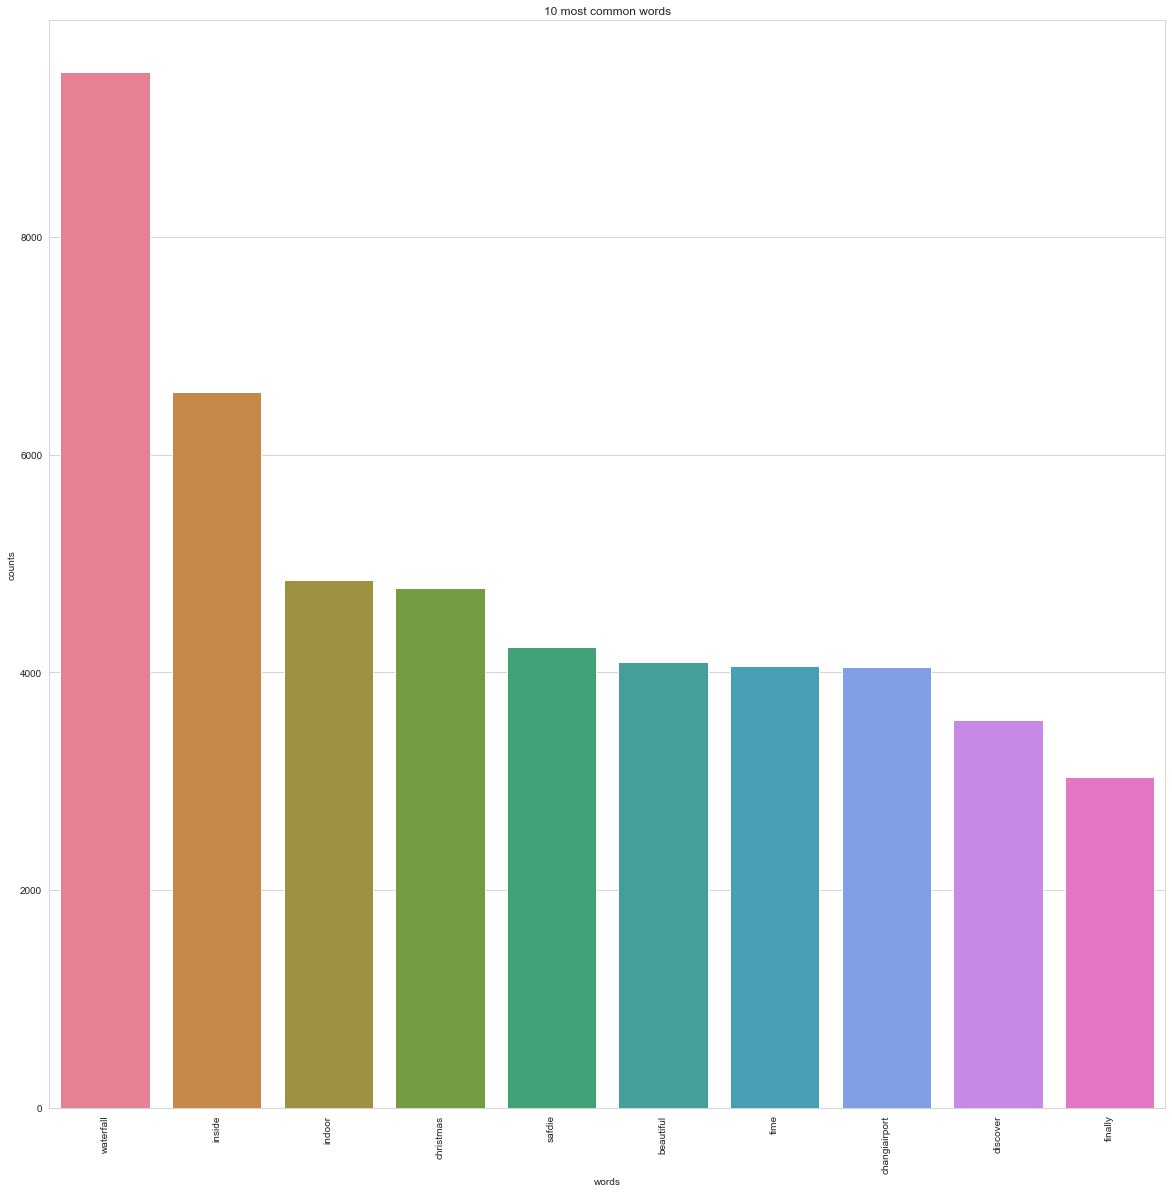

In [7]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as npimport 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(20, 20))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=4, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(tweets['clean_tweet'])# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [8]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 4), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(tweets['clean_tweet'], 20)
mydict={}
for word, freq in common_words:
    print(word,freq)
    bigram_df  = pd.DataFrame(common_words, columns = ['ngram' , 'count'])
bigram_df.groupby('ngram').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

indoor waterfall 3609
safdie architects 2993
canopy park 2961
rain vortex 2923
architecture safdiearchitects 1807
special jury 1807
jury award 1807
special jury award 1807
discover safdie 1751
discover safdie architects 1751
entertainment retail 1718
retail complex 1718
entertainment retail complex 1718
water fall 1628
custom cut 1242
award mapic 1242
mapic awards 1242
jury award mapic 1242
award mapic awards 1242
special jury award mapic 1242


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\p1234\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\p1234\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



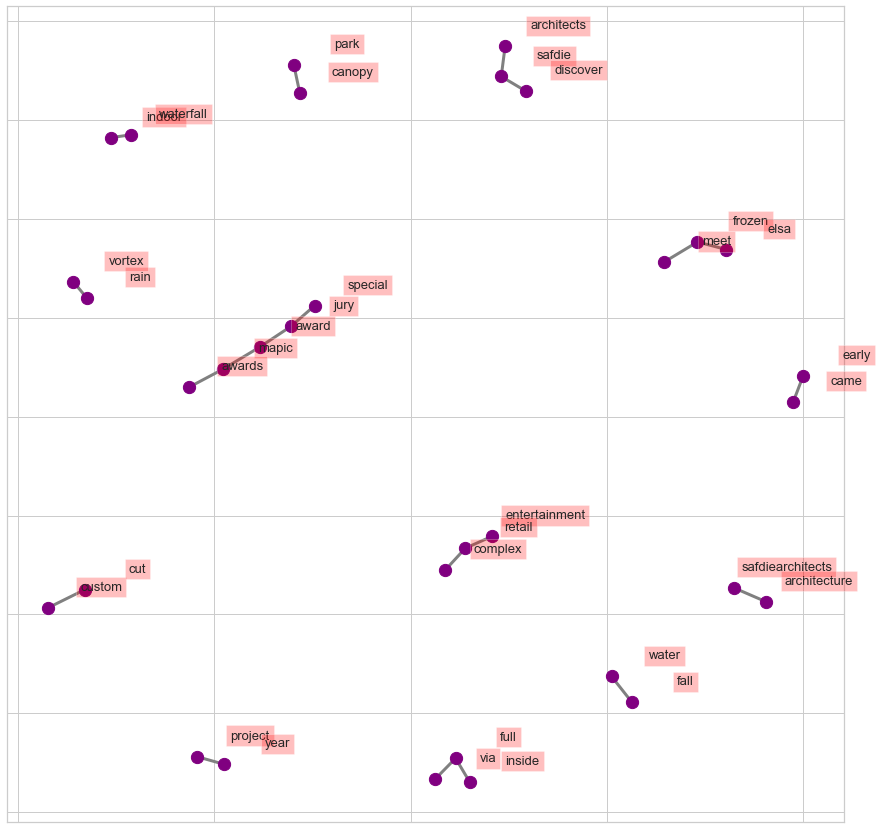

In [9]:
words_in_tweet= [tweet.lower().split() for tweet in tweets.clean_tweet]

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
#tweets_nsw = [[word for word in tweet_words if not word in stop_words] for tweet_words in words_in_tweet]

tweets_nsw=words_in_tweet
collection_words = ['experience', 'new']

tweets_nsw_nc = [[w for w in word if not w in collection_words] for word in tweets_nsw]

# Create list of lists containing bigrams in tweets
terms_bigram = [list(nltk.bigrams(tweet)) for tweet in tweets_nsw_nc]
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)
bigram_dff = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_dff

# Create dictionary of bigrams and their counts
d = bigram_dff.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

#G.add_node("china", weight=100)

fig, ax = plt.subplots(figsize=(15, 15))

pos = nx.spring_layout(G, k=5)
#pos = nx.nx_pydot.pydot_layout(G, prog='dot')
#pos = nx.fruchterman_reingold_layout(G, k=10, scale=50, seed=101)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=15,
                 width=3,
                 node_size=150,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    #x, y = value[0]+1, value[1]+2
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [12]:
data = tweets.clean_tweet.values.tolist()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['canopy', 'park']]


Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [13]:
# Build the bigram and trigram models
from gensim.models import Phrases
from gensim.models.phrases import Phraser 

phrases = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(phrases)
trigram_mod = Phrases(bigram_mod[data_words])

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['canopy', 'park']


The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [15]:
tfidf = gensim.models.TfidfModel(corpus) # step 1 -- initialize a model
corpus_tfidf = tfidf[corpus]  # step 2 -- use the model to transform vector

In [16]:
id2word[0]

'canopy'

In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('canopy', 1), ('park', 1)]]

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.
random_state - this serves as a seed (in case you wanted to repeat exactly the training process)

chunksize - number of documents to consider at once (affects the memory consumption)

update_every - update the model every update_every chunksize chunks (essentially, this is for memory consumption optimization)

passes - how many times the algorithm is supposed to pass over the whole corpus

alpha - to cite the documentation:

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)



In [37]:
# Build LDA model
lda_dom = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [20]:
# Print the Keyword in the 6 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.043*"waterfall" + 0.032*"christmas" + 0.025*"discover" + 0.021*"indoor" + 0.021*"award" + 0.017*"like" + 0.017*"going" + 0.017*"special" + 0.016*"changiairport" + 0.016*"architects"'), (1, '0.021*"waterfall" + 0.021*"vortex" + 0.021*"rain" + 0.021*"early" + 0.013*"worlds" + 0.013*"indoor" + 0.013*"store" + 0.013*"changiairport" + 0.012*"one" + 0.012*"gift"'), (2, '0.028*"canopy" + 0.028*"park" + 0.023*"night" + 0.022*"beautiful" + 0.022*"back" + 0.017*"part" + 0.017*"finally" + 0.017*"entertainment" + 0.017*"complex" + 0.017*"retail"'), (3, '0.059*"inside" + 0.034*"via" + 0.030*"full" + 0.015*"much" + 0.015*"take" + 0.014*"great" + 0.014*"love" + 0.010*"qatar" + 0.010*"bound" + 0.010*"wants"')]


Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [21]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.397144807440178

Coherence Score:  0.6257276808590728


In [38]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_dom.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_dom, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.179323395932538

Coherence Score:  0.5917590763370814


In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\p1234\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.059179  0.270356       1        1  27.786848
0      0.072531  0.155315       2        1  27.441641
3     -0.381530 -0.125251       3        1  24.210499
2      0.249821 -0.300421       4        1  20.561003, topic_info=    Category         Freq             Term        Total  loglift  logprob
58   Default  7475.000000           inside  7475.000000  30.0000  30.0000
59   Default  4370.000000              via  4370.000000  29.0000  29.0000
57   Default  3764.000000             full  3764.000000  28.0000  28.0000
20   Default  5237.000000        christmas  5237.000000  27.0000  27.0000
0    Default  3009.000000           canopy  3009.000000  26.0000  26.0000
1    Default  3009.000000             park  3009.000000  25.0000  25.0000
304  Default  3613.000000         discover  3613.000000  24.0000  24.0000
5    Default  9784.000000        waterfall  9784.000000  23.0000  23.0000
219  Default  3017.000000            award  3017.000000  22.0000  22.0000
54   Default  3022.000000             rain  3022.000000  21.0000  21.0000
55   Default  3022.000000           vortex  3022.000000  20.0000  20.0000
76   Default  2426.000000            night  2426.000000  19.0000  19.0000
47   Default  2998.000000            early  2998.000000  18.0000  18.0000
52   Default  2361.000000             back  2361.000000  17.0000  17.0000
6    Default  2474.000000             like  2474.000000  16.0000  16.0000
2    Default  2465.000000            going  2465.000000  15.0000  15.0000
271  Default  2434.000000          special  2434.000000  14.0000  14.0000
392  Default  4893.000000           indoor  4893.000000  13.0000  13.0000
73   Default  1841.000000             part  1841.000000  12.0000  12.0000
149  Default  1808.000000    entertainment  1808.000000  11.0000  11.0000
148  Default  1808.000000          complex  1808.000000  10.0000  10.0000
75   Default  1805.000000             best  1805.000000   9.0000   9.0000
15   Default  1745.000000             shot  1745.000000   8.0000   8.0000
79   Default  3570.000000             time  3570.000000   7.0000   7.0000
43   Default  1865.000000             much  1865.000000   6.0000   6.0000
225  Default  2990.000000          finally  2990.000000   5.0000   5.0000
19   Default  4214.000000    changiairport  4214.000000   4.0000   4.0000
152  Default  2391.000000           retail  2391.000000   3.0000   3.0000
231  Default  4181.000000        beautiful  4181.000000   2.0000   2.0000
423  Default  1853.000000             jury  1853.000000   1.0000   1.0000
..       ...          ...              ...          ...      ...      ...
15    Topic4  1744.250610             shot  1745.001465   1.5813  -4.1224
328   Topic4  1224.290039           taking  1225.040894   1.5812  -4.4764
221   Topic4  1227.172974  congratulations  1227.926514   1.5812  -4.4741
222   Topic4  1227.172974          winning  1227.926514   1.5812  -4.4741
151   Topic4  1215.199707     naturethemed  1215.950562   1.5812  -4.4839
239   Topic4  1221.912354              got  1222.687622   1.5811  -4.4784
246   Topic4  1178.834839           posted  1179.585693   1.5811  -4.5142
247   Topic4  1178.834839            video  1179.585693   1.5811  -4.5142
183   Topic4  1173.871704            cream  1174.622559   1.5811  -4.5185
184   Topic4  1173.871704              ice  1174.622559   1.5811  -4.5185
91    Topic4  1172.321411            named  1173.072266   1.5811  -4.5198
161   Topic4  1172.132446     yuiisamainsg  1172.883301   1.5811  -4.5199
66    Topic4  1163.968506              pls  1164.719360   1.5811  -4.5269
16    Topic4  1162.913086             wide  1163.663940   1.5811  -4.5278
556   Topic4   641.145630         manulife   641.896545   1.5806  -5.1233
554   Topic4   641.145630         bouncing   641.896545   1.5806  -5.1233
555   Topic4   641.145630            clips   641.896545   1.5806  -5.1233
557   T

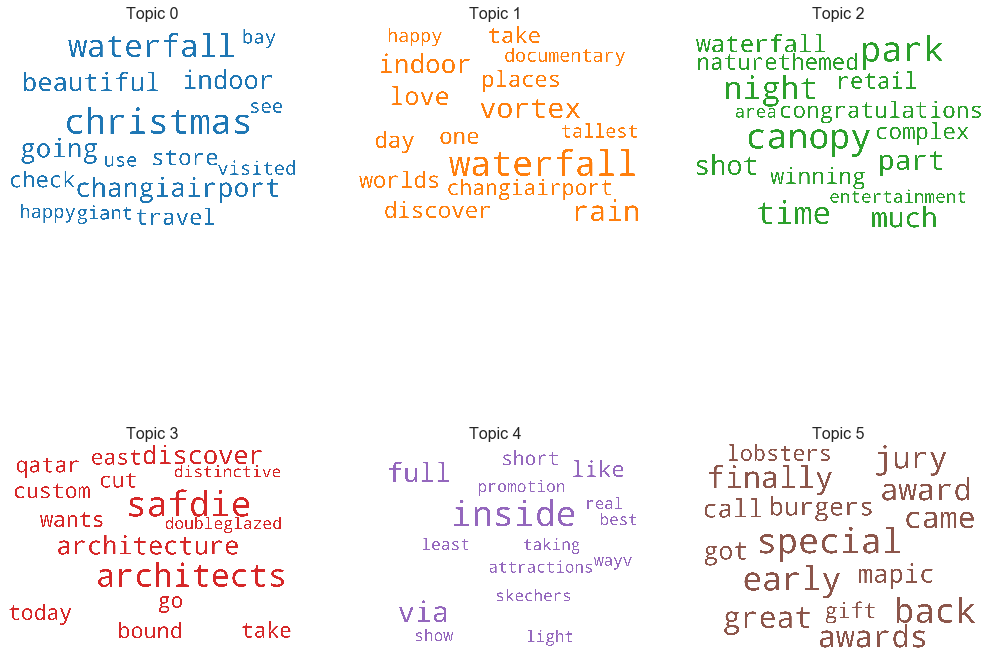

In [42]:
# Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_dom.show_topics(num_words=15,formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics, random_state=100,update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=20, step=2)

# Show graph
limit=20
start=2 
step=2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Finding out the dominant topic for each component

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

In [28]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                clean_words = " ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords,clean_words]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','clean_words']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_dom, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords','clean_words', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             2.0              0.9803   
1            1             0.0              0.9905   
2            2             0.0              0.9905   
3            3             2.0              0.9966   
4            4             1.0              0.2823   
5            5             0.0              0.5965   
6            6             3.0              0.9805   
7            7             1.0              0.2823   
8            8             3.0              0.9943   
9            9             1.0              0.9947   

                                            Keywords  \
0  canopy, park, night, beautiful, back, part, fi...   
1  waterfall, christmas, discover, indoor, award,...   
2  waterfall, christmas, discover, indoor, award,...   
3  canopy, park, night, beautiful, back, part, fi...   
4  waterfall, vortex, rain, early, worlds, indoor...   
5  waterfall, christmas, discover, indoor, award,...   
6  inside, via, full, much, take, great, love, qa...   
7  waterfall, vortex, rain, early, worlds, indoor...   
8  inside, via, full, much, take, great, love, qa...   
9  waterfall, vortex, rain, early, worlds, indoor...   

                                         clean_words  \
0  canopy park night beautiful back part finally ...   
1  waterfall christmas discover indoor award like...   
2  waterfall christmas discover indoor award like...   
3  canopy park night beautiful back part finally ...   
4  waterfall vortex rain early worlds indoor stor...   
5  waterfall christmas discover indoor award like...   
6  inside via full much take great love qatar bou...   
7  waterfall vortex rain early worlds indoor stor...   
8  inside via full much take great love qatar bou...   
9  waterfall vortex rain early worlds indoor stor...   

                                                Text  
0                                     [canopy, park]  
1                      [stop, see, waterfall, going]  
2               [something, like, umuahia, thinking]  
3  [mandatory, shot, sadly, samsungs, wide, shot,...  
4                                                 []  
5  [blue, christmas, changiairport, christmas, ho...  
6                        [steerexplore, steescapade]  
7                                                 []  
8  [automated, boarding, pass, immigration, clear...  
9  [ultimate, food, guide, restaurants, food, pla...

In [31]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [32]:
def topic_sentiment(topic_no,tweets):
    #sentiment score using textblob
    #del tweets['Keywords']
    #del tweets['clean_words']
    tweets = tweets[tweets.Dominant_Topic ==topic_no]
    tweets["Text"]= tweets["Text"].str.join(" ") 
    tweets = tweets[~tweets['Text'].isnull()] 
    tweets['sentiment'] = tweets['Text'].map(lambda text: TextBlob(text).sentiment)
    tweets['polarity'] = tweets['Text'].map(lambda text: TextBlob(text).sentiment.polarity)
    tweets['subjectivity'] = tweets['Text'].map(lambda text: TextBlob(text).sentiment.subjectivity)
    tweets['tweet_len'] = tweets['Text'].astype(str).apply(len)
    tweets['word_count'] = tweets['Text'].apply(lambda x: len(str(x).split()))
    tweets['vaderSentiment']=tweets.Text.apply(sentiment_analyzer_scores)
    tweets['compound'] = tweets['vaderSentiment'].map(lambda text: text['compound'])
    tweets['label'] = tweets['compound'].apply(lambda x: int(0) if x>0 else int(1))
    return tweets

In [49]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

sentiment= topic_sentiment(3.0,df_dominant_topic)

sentiment.label.loc[(sentiment['compound'] > 0)] = 'Positive'
sentiment.label.loc[(sentiment['compound'] == 0)] = 'Neutral'
sentiment.label.loc[(sentiment['compound'] < 0)] = 'Negative'

sentiment['label'].iplot(
    kind='hist',
    bins=20,
    xTitle='Sentiment',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

sentiment['compound'].iplot(
    kind='hist',
    bins=20,
    xTitle='Sentiment',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

Negative Sentiment Word Cloud:


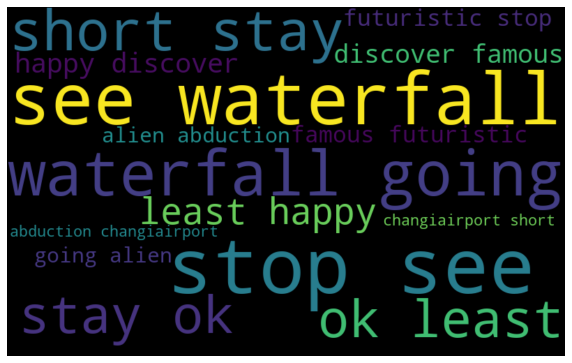

Negative Sentiment Word Cloud:


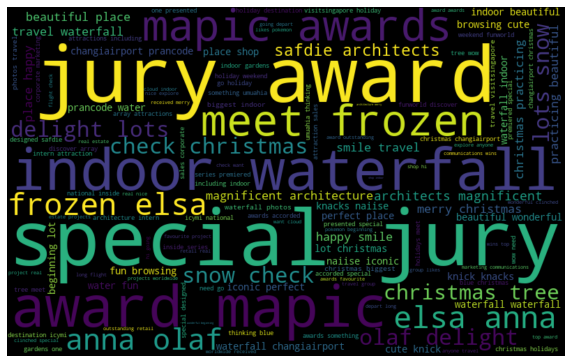

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Negative Sentiment Word Cloud:")
#wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
negative_words = ' '.join([text for text in sentiment['Text'][sentiment['label'] =='Negative']])
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Positive Sentiment Word Cloud:")
#wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
negative_words = ' '.join([text for text in sentiment['Text'][sentiment['label'] =='Positive']])
wordcloud = WordCloud(width=800, height=500,random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()